## Machine Learning applied to identify Active Antimicobrial Peptides

In this notebook is described all the procedure used to train and test the Activity model.

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import pickle
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

%matplotlib inline

In [2]:
# This function wil convert the undefined MIC values or MIC > 8 to 0.
def convert_mic(mic_value):
    if type(mic_value) == str and mic_value.startswith('>'):
        return 0
    elif float(mic_value) > 8:
        return 0
    else:
        return 1
    
convert_mic('>64')

0

In [3]:
# Load meta data
meta_data = pd.read_excel('data/Cumulative_Peptide_data_PG1.xlsx', index_col=0)
meta_data['MBC'] = [convert_mic(x) for x in meta_data['MBC']]
meta_data

,ID,Sequence,MBC,%Hemolysis
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069
...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367
92,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085
93,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292
94,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276


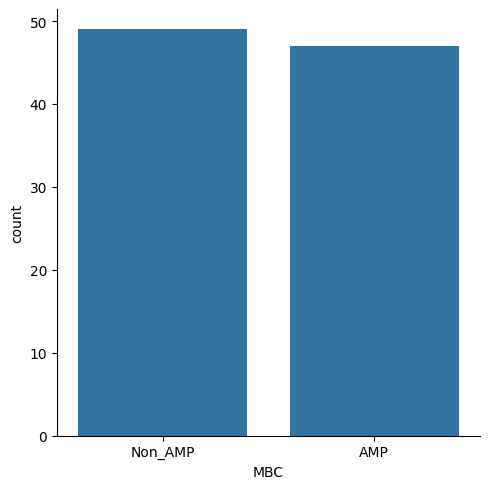

In [4]:
# Create the new target selectivity
sns.catplot(data=meta_data, x='MBC', kind='count')
plt.xticks([0,1], ['Non_AMP', 'AMP'])
plt.show()

## Define the Model

In [5]:
# # creates a empty dictionary, and updates it with the embedds
dir_path = 'data/embedding/esm2_15B_PG1/'

embeddings = {}
for file in os.listdir(dir_path):
    file_path = str(dir_path) + file 
    label = file.split('.pt')[0]
    embeddings[label] = np.array(torch.load(file_path)['mean_representations'][48])

# here I creating a dictionary with ID as key and semantic value as value 
data = meta_data.merge(pd.DataFrame.from_dict(embeddings, orient='index'), how='inner', left_on='ID', right_index=True)
data

,ID,Sequence,MBC,%Hemolysis,0,1,2,3,4,5,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,PG-1.37,HVRRLCYCRRRFCACVGS,1,2.600000,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,PG-1.20d,RGGRLRYCRRRFCVSVGR,1,1.607281,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,PG-1.62,RGGRLCYCRRRFCTCVGR,1,3.233927,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,PG-1.12A,RGGRLCYCRRRACVCVGR,1,12.103021,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,PG-1.16A,RGGRLCYCRRRFCVCAGR,1,15.821069,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,PG-1.32,HGWRLCYCRRRFCVCVGC,0,35.460367,0.007245,-0.115889,-0.040796,0.235570,-0.216340,0.226666,...,-0.166121,-0.146094,0.080064,-0.143502,0.155125,-0.067742,0.087349,-0.027154,-0.214921,0.023557
92,PG-1.60,RGGRLCYCRRRFCVCVGF,0,36.664085,0.143025,-0.030791,-0.110694,0.109217,-0.223111,0.105739,...,-0.119124,-0.189840,-0.030339,-0.218860,0.098898,-0.174355,0.023488,-0.059298,-0.252023,0.029996
93,PG-1.25,RGWRLCYCRRRFCVCVGH,0,46.397292,0.068697,-0.038422,-0.142241,0.184863,-0.232976,0.162749,...,-0.180917,-0.172996,0.046710,-0.179037,0.106190,-0.103997,-0.029128,0.000693,-0.243295,0.019351
94,PG-1.7,RRWCLCFCRRRFCVCVCR,0,51.181276,0.066839,-0.037917,-0.087912,0.137855,-0.218455,0.279858,...,-0.167717,-0.251613,-0.086687,-0.231941,0.015133,-0.017062,0.048716,-0.028251,-0.203544,-0.114390


In [6]:
 # define target to evaluete the model
target = data["MBC"]

In [7]:
# define target
features = data.iloc[:, meta_data.shape[1]:]
features.head()

,0,1,2,3,4,5,6,7,8,9,...,5110,5111,5112,5113,5114,5115,5116,5117,5118,5119
0,0.056671,-0.074099,-0.040746,0.217794,-0.197767,0.223628,-0.119524,0.080779,-0.021853,0.285255,...,-0.130863,-0.107892,0.140624,-0.169443,0.165775,-0.120193,0.094954,-0.000617,-0.199790,0.001056
1,0.133009,-0.124348,-0.109747,0.222604,-0.261453,0.138052,-0.132696,0.162016,-0.073308,0.382890,...,-0.105108,-0.053451,0.092585,-0.201894,0.094672,-0.104331,0.135752,0.036512,-0.230271,0.020399
2,0.155696,-0.016959,-0.179328,0.153639,-0.241203,0.130882,-0.101294,0.178330,-0.043959,0.144877,...,-0.160722,-0.136943,0.049061,-0.175572,0.109034,-0.239965,-0.050614,-0.096664,-0.249927,0.020688
3,0.056310,-0.137829,-0.098538,0.162526,-0.252675,0.163847,-0.120923,0.205509,-0.078092,0.267088,...,-0.124351,-0.181434,0.037783,-0.201551,0.092573,-0.168867,0.078524,-0.003103,-0.212419,0.049512
4,0.122564,-0.024471,-0.127546,0.165324,-0.258667,0.142153,-0.093198,0.185513,-0.060469,0.173319,...,-0.155189,-0.155856,0.061196,-0.220575,0.092058,-0.220014,0.025014,-0.053914,-0.198191,0.036471


## Split the data into train and test
this procedures is important to be done before any feature selection to avoid data leakage

In [8]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

print(f'Train set shape: {X_train.shape}, Test set shape: {X_test.shape}')

Train set shape: (76, 5120), Test set shape: (20, 5120)


## Running the models

In [14]:
# create an empty dataframe to store results
results = pd.DataFrame()
results_cv = pd.DataFrame()

# create a list of classifiers to test
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    GaussianNB(),
    SVC(),
    RandomForestClassifier()
]

# create a dictionary of hyperparameters to search over for each classifier
param_grids = [
    {'n_neighbors': [5, 10, 30, 50], 'weights': ['uniform', 'distance'], 'p': [1, 2]},
    {'max_depth': [None, 2, 4, 6], 'min_samples_split': [2, 4, 6]},
    {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]},
    {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 1, 0.1, 0.01], 'max_iter': [-1], 'class_weight': [None, 'balanced']},
    {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 50], 'min_samples_split': [5, 10, 50], 'max_features': ['sqrt', 'log2']}
]

# create a list of names for the classifiers for printing results
model_names = ["KNN", "Decision Tree", 'GaussianNB', "SVM", 'RandomForest']


# loop over the classifiers and hyperparameter grids
for name, clf, param_grid in zip(model_names, classifiers, param_grids):
    # create a GridSearchCV object with 5-fold cross-validation
    grid_search = GridSearchCV(clf, param_grid, cv=10, n_jobs=10,)
    
    # fit the grid search object to the training data
    grid_search.fit(X_train.values, y_train)
    
    # k-fold cross-validation on the training set
    accuracy_cv_scores = cross_val_score(grid_search, X_train.values, y_train, cv=10, scoring='accuracy', n_jobs=10)
    recall_cv_scores = cross_val_score(grid_search, X_train.values, y_train, cv=10, scoring='recall', n_jobs=10)
    precision_cv_scores = cross_val_score(grid_search, X_train.values, y_train, cv=10, scoring='precision', n_jobs=10)
    f1_cv_scores = cross_val_score(grid_search, X_train.values, y_train, cv=10, scoring='f1', n_jobs=10)


    # make predictions on the test data using the best model found by the grid search
    train_y_pred = grid_search.best_estimator_.predict(X_train.values)
    test_y_pred = grid_search.best_estimator_.predict(X_test.values)
    
    best_score = str(grid_search.best_score_.round(2))
    
    # evaluate the performance of the best model on the train data using accuracy score
    train_accuracy = metrics.accuracy_score(y_train, train_y_pred)
    train_recall = metrics.recall_score(y_train, train_y_pred)
    train_precision = metrics.precision_score(y_train, train_y_pred)
    train_f1_score = metrics.f1_score(y_train, train_y_pred)

    # evaluate the performance of the best model on the test data using accuracy score
    test_accuracy = metrics.accuracy_score(y_test, test_y_pred)
    test_recall = metrics.recall_score(y_test, test_y_pred)
    test_precision = metrics.precision_score(y_test, test_y_pred)
    test_f1_score = metrics.f1_score(y_test, test_y_pred)
    
    print(name)
    print(f'Train Accuracy: {train_accuracy.round(2)}, Train Recall: {train_recall.round(2)}, Train Precision: {train_precision.round(2)}')
    print(f'Test Accuracy: {test_accuracy.round(2)}, Test Recall: {test_recall.round(2)}, Test Precision: {test_precision.round(2)}')
    print()

    # Saving results
    res_dict = {}
    res_dict["embedding"] = 'esm2_15B'
    res_dict["embed_size"] = features.shape[1]
    res_dict["model"] = name

    res_dict["Train_Accuracy"] = train_accuracy.round(2)
    res_dict["Train_recall"] = train_recall.round(2)
    res_dict["Train_precision"] = train_precision.round(2)
    res_dict["Train_f1"] = train_f1_score.round(2)

    res_dict["Test_Accuracy"] = test_accuracy.round(2)
    res_dict["Test_recall"] = test_recall.round(2)
    res_dict["Test_precision"] = test_precision.round(2)
    res_dict["Test_f1"] = test_f1_score.round(2)


    res_dict['best_params'] = str(grid_search.best_params_)
 
    # updating data frame with results
    results = pd.concat([results, pd.DataFrame(res_dict, index=[0])]).reset_index(drop=True)
    
    # save results from cross-validation
    res_cv_dict = {
        "model": [name for i in range(10)],
        "Accuracy_CV_scores": accuracy_cv_scores,
        "Recall_CV_scores": recall_cv_scores,
        "Precision_CV_scores": precision_cv_scores,
        "F1_CV_scores": f1_cv_scores,
    }
    # updating data frame with results
    results_cv = pd.concat([results_cv, pd.DataFrame(res_cv_dict)]).reset_index(drop=True)

results.to_excel('results/results_classification_MIC_new.xlsx')
results_cv.to_excel('results_cv/results_cv_classification_MIC_new.xlsx')

KNN
Train Accuracy: 0.99, Train Recall: 0.97, Train Precision: 1.0
Test Accuracy: 0.65, Test Recall: 0.91, Test Precision: 0.62

Decision Tree
Train Accuracy: 0.99, Train Recall: 0.97, Train Precision: 1.0
Test Accuracy: 0.85, Test Recall: 0.82, Test Precision: 0.9

GaussianNB
Train Accuracy: 0.78, Train Recall: 0.86, Train Precision: 0.72
Test Accuracy: 0.85, Test Recall: 0.91, Test Precision: 0.83

SVM
Train Accuracy: 0.99, Train Recall: 1.0, Train Precision: 0.97
Test Accuracy: 0.9, Test Recall: 0.91, Test Precision: 0.91

RandomForest
Train Accuracy: 0.99, Train Recall: 1.0, Train Precision: 0.97
Test Accuracy: 0.8, Test Recall: 0.82, Test Precision: 0.82



## Results Visualization

In [28]:
results_cv = pd.read_excel('results/results_cv_classification_MIC_new.xlsx', index_col=0)
results_cv.groupby('model').mean()

,Accuracy_CV_scores,Recall_CV_scores,Precision_CV_scores,F1_CV_scores
model,,,,
Decision Tree,0.576786,0.566667,0.541667,0.483333
GaussianNB,0.564286,0.608333,0.568333,0.571349
KNN,0.642857,0.775000,0.638810,0.664156
RandomForest,0.685714,0.666667,0.598333,0.565397
SVM,0.510714,0.633333,0.471190,0.533911


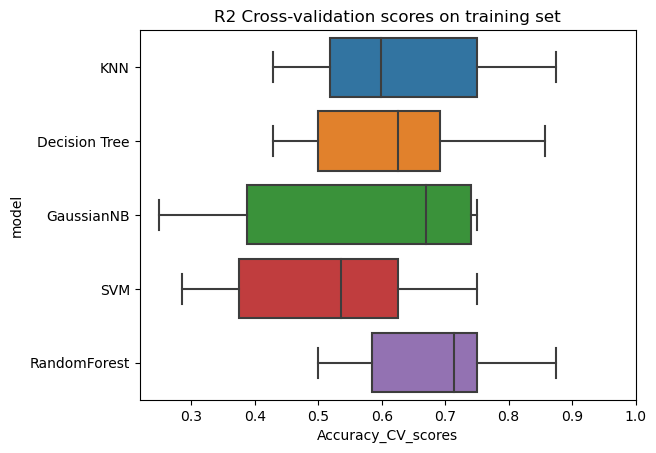

In [29]:
sns.boxplot(data=results_cv, y='model', x='Accuracy_CV_scores',showfliers=False)
plt.title('R2 Cross-validation scores on training set')
plt.xlim(right=1)
plt.show()

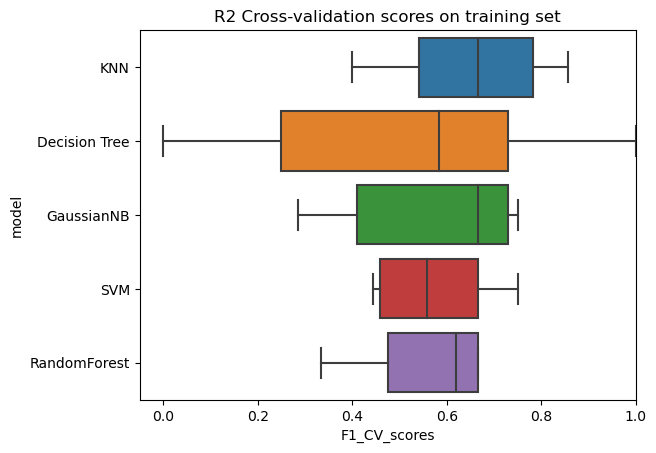

In [21]:
sns.boxplot(data=results_cv, y='model', x='F1_CV_scores',showfliers=False)
plt.title('R2 Cross-validation scores on training set')
plt.xlim(right=1)
plt.show()

## Train x Test

In [10]:
results = pd.read_excel('results/results_classification_MIC_new.xlsx', index_col=0)
results

,embedding,embed_size,model,Train_Accuracy,Train_recall,Train_precision,Train_f1,Test_Accuracy,Test_recall,Test_precision,Test_f1,best_params
0,esm2_15B,5120,KNN,0.99,0.97,1.00,0.99,0.65,0.91,0.62,0.74,"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"
1,esm2_15B,5120,Decision Tree,0.99,0.97,1.00,0.99,0.85,0.82,0.90,0.86,"{'max_depth': None, 'min_samples_split': 2}"
2,esm2_15B,5120,GaussianNB,0.78,0.86,0.72,0.78,0.85,0.91,0.83,0.87,{'var_smoothing': 1e-09}
3,esm2_15B,5120,SVM,0.99,1.00,0.97,0.99,0.90,0.91,0.91,0.91,"{'C': 100, 'class_weight': 'balanced', 'gamma'..."
4,esm2_15B,5120,RandomForest,0.99,1.00,0.97,0.99,0.80,0.82,0.82,0.82,"{'max_depth': 5, 'max_features': 'sqrt', 'min_..."


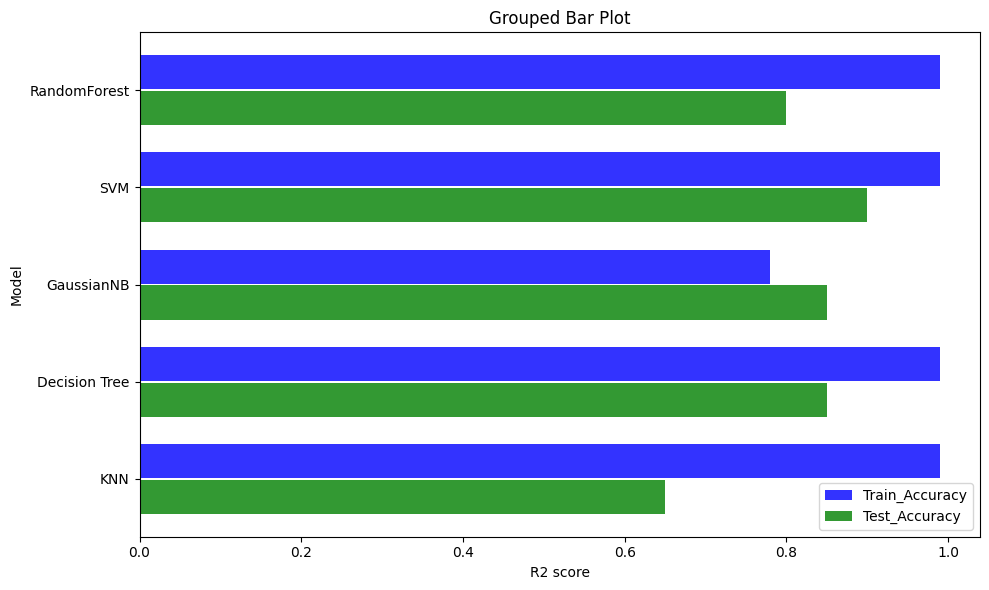

In [11]:
# Replace 'column1' and 'column2' with the names of the columns you want to plot
column1 = 'Train_Accuracy'
column2 = 'Test_Accuracy'

# Create a bar plot with two bars per group
fig, ax = plt.subplots(figsize=(10, 6))
y = np.arange(len(results))
bar_height = 0.35
opacity = 0.8

# +/- 0.01 is to create a small space between bars
rects1 = ax.barh(y + bar_height/2 + 0.01, results[column1], bar_height, 
                 alpha=opacity, color='b', label=column1)
rects2 = ax.barh(y - bar_height/2 - 0.01, results[column2], bar_height,
                 alpha=opacity, color='g', label=column2)


# Add labels and legend
ax.set_ylabel('Model')
ax.set_xlabel('R2 score')
ax.set_title('Grouped Bar Plot')
ax.set_yticks(y)
ax.set_yticklabels(results['model'])
ax.legend()
plt.tight_layout()
plt.show()

## Fine Tunning Model with best hyperparameter found with Gridsearch


To determine if the model is overfitting, it's important to evaluate its performance on a validation set or using cross-validation.   
If the model's performance on the validation set is significantly worse than its performance on the training set, then it may be overfitting.   
In such cases, it may be necessary to adjust the hyperparameters of the model or to use a less complex kernel function.




## svc

In [12]:
results.iloc[3, 11]

"{'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1}"

In [13]:
svc= SVC(kernel= 'rbf',
            C= 100,
            gamma='scale',
            max_iter=-1,
            class_weight= 'balanced',
            probability = True
            )

# fit the model
svc.fit(X_train.values, y_train)

# print Accuracy score
print(f'Train R2 score: {svc.score(X_train.values, y_train):.2f}')
print(f'Test R2 score: {svc.score(X_test.values, y_test):.2f}')

Train R2 score: 0.99
Test R2 score: 0.90


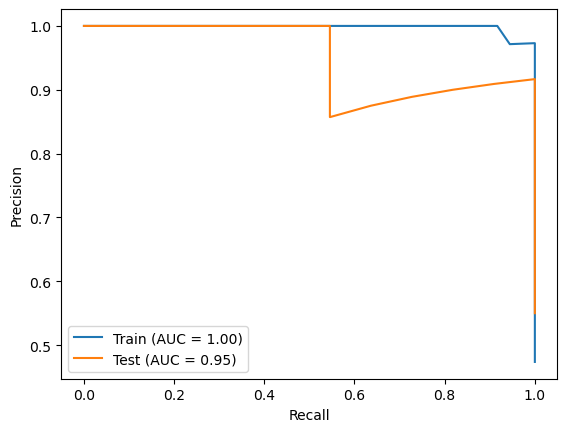

In [47]:
# Predict probabilities on the training and testing sets
y_train_proba = svc.predict_proba(X_train)[:, 1]
y_test_proba = svc.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## RF

In [49]:
results.iloc[4,11]

"{'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 50}"

In [50]:
RF= RandomForestClassifier(
    max_depth=5, 
    max_features='sqrt', 
    min_samples_split=5,
    n_estimators=50
)

RF.fit(X_train, y_train)

# print Accuracy score
print(f'Train R2 score: {RF.score(X_train.values, y_train):.2f}')
print(f'Test R2 score: {RF.score(X_test.values, y_test):.2f}')

Train R2 score: 0.99
Test R2 score: 0.90


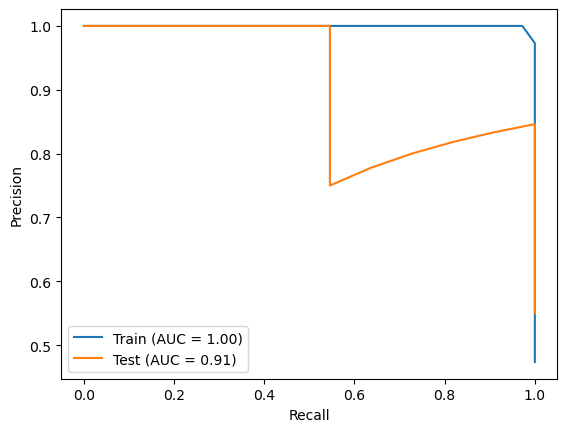

In [51]:
# Predict probabilities on the training and testing sets
y_train_proba = RF.predict_proba(X_train)[:, 1]
y_test_proba = RF.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## DecisionTreeClassifier

In [52]:
results.iloc[1,11]

"{'max_depth': None, 'min_samples_split': 2}"

In [53]:
DT= DecisionTreeClassifier(
    max_depth=6, 
    min_samples_split=6
)

DT.fit(X_train, y_train)

# print Accuracy score
print(f'Train R2 score: {DT.score(X_train.values, y_train):.2f}')
print(f'Test R2 score: {DT.score(X_test.values, y_test):.2f}')

Train R2 score: 0.99
Test R2 score: 0.85


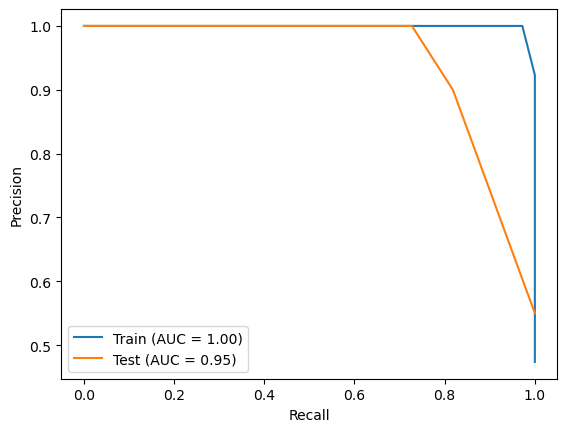

In [54]:
# Predict probabilities on the training and testing sets
y_train_proba = DT.predict_proba(X_train)[:, 1]
y_test_proba = DT.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Gaussian NB

In [14]:
results.iloc[2, 11]

"{'var_smoothing': 1e-09}"

In [15]:
gnb = GaussianNB(
    var_smoothing= 1e-09,
    )

gnb.fit(X_train, y_train)

# print Accuracy score
print(f'Train R2 score: {gnb.score(X_train.values, y_train):.2f}')
print(f'Test R2 score: {gnb.score(X_test.values, y_test):.2f}')

Train R2 score: 0.78
Test R2 score: 0.85


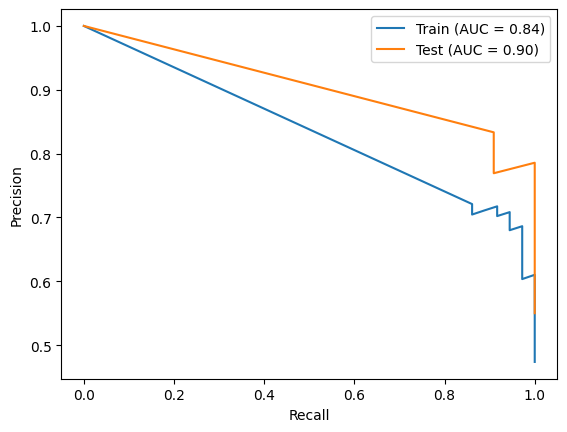

In [16]:
# Predict probabilities on the training and testing sets
y_train_proba = gnb.predict_proba(X_train)[:, 1]
y_test_proba = gnb.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

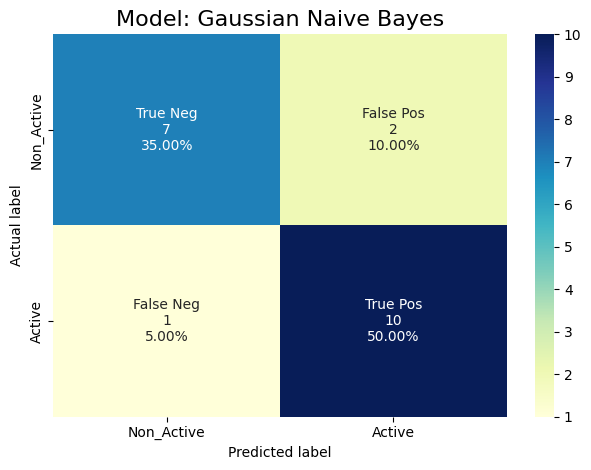

In [18]:
#confusion_matrix, 
mic_true = y_test
mic_pred = gnb.predict(X_test.values)

conf_m = metrics.confusion_matrix(mic_true, mic_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in conf_m.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in conf_m.flatten()/np.sum(conf_m)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)


labelsx = ['Non_Active', 'Active']
sns.heatmap(conf_m, annot=labels, fmt='', cmap="YlGnBu", yticklabels=labelsx, xticklabels=labelsx)
plt.title('Model: Gaussian Naive Bayes', fontsize=16)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.tight_layout()

In [19]:
accuracy = metrics.accuracy_score(mic_true, mic_pred)
recall = metrics.recall_score(mic_true, mic_pred)
precision = metrics.precision_score(mic_true, mic_pred)
f1_score = metrics.f1_score(mic_true, mic_pred)

print(f'Accuracy: {accuracy:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Precision: {precision:.2f}')
print(f'F1 Score: {f1_score:.2f}')

Accuracy: 0.85
Recall: 0.91
Precision: 0.83
F1 Score: 0.87


In [22]:
df_dict={'Feature': 'Activity', 'Accuracy': accuracy, 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score}
df = pd.DataFrame(df_dict, index=[0])
df = df.melt(id_vars=['Feature'], value_vars=['Accuracy', 'Recall', 'Precision', 'F1 Score'], var_name='Metric', value_name='Score')
df

,Feature,Metric,Score
0,Activity,Accuracy,0.850000
1,Activity,Recall,0.909091
2,Activity,Precision,0.833333
3,Activity,F1 Score,0.869565


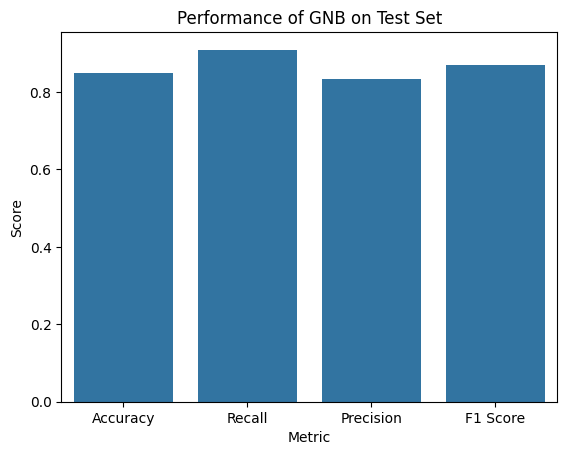

In [30]:

sns.barplot(data=df, x='Metric', y='Score')
plt.title('Performance of GNB on Test Set', fontsize=12)
plt.show()

## KNeighborsClassifier

In [59]:
results.iloc[0, 11]

"{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}"

In [61]:
knn = KNeighborsClassifier(
    n_neighbors=5,
    p= 1,
    weights='distance')

knn.fit(X_train, y_train)

# print Accuracy score
print(f'Train R2 score: {knn.score(X_train.values, y_train):.2f}')
print(f'Test R2 score: {knn.score(X_test.values, y_test):.2f}')

Train R2 score: 0.99
Test R2 score: 0.65


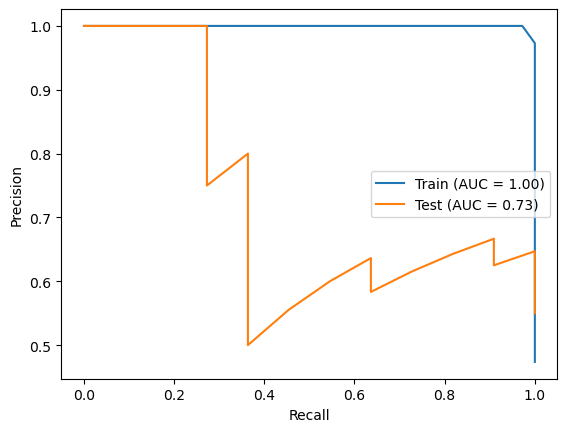

In [30]:
# Predict probabilities on the training and testing sets
y_train_proba = knn.predict_proba(X_train)[:, 1]
y_test_proba = knn.predict_proba(X_test)[:, 1]

# Compute precision-recall curves and AUCs for the training and testing sets
train_precision, train_recall, _ = precision_recall_curve(y_train, y_train_proba)
test_precision, test_recall, _ = precision_recall_curve(y_test, y_test_proba)
train_auc = auc(train_recall, train_precision)
test_auc = auc(test_recall, test_precision)

# Plot the precision-recall curves and AUCs for the training and testing sets
plt.plot(train_recall, train_precision, label=f'Train (AUC = {train_auc:.2f})')
plt.plot(test_recall, test_precision, label=f'Test (AUC = {test_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Save the model

GNB has less change to be overfitting

In [ ]:
#pickle.dump(gnb, open('models/GNB_cls_esm2_15B_MIC.pkl', 'wb'))